In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import os

![ViT Image Processing](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*_c8SqxPMY_dsApyvDJ8HtA.gif)

## Variables

In [13]:
# Hyperparameters
batch_size = 128
img_size = 32           # CIFAR-10 images are 32x32
patch_size = 4          # (32/4=8 → 8x8 = 64 patches)
num_channels = 3        # RGB images
num_patches = (img_size // patch_size) ** 2
embed_dim = 192          # Must be divisible by num_heads
num_heads = 8
mlp_dim = 4 * embed_dim
transformer_layers = 6  # Deeper network
dropout_rate = 0.1
learning_rate = 0.003
weight_decay = 0.05
epochs = 50
warmup_epochs = 5       # For linear warmup

# Normalization Parameters
mean = [0.4914,0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]

# Output Class
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

## Image Transformer

In [14]:
# transform train for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# transform Test
transform_test = transforms.Compose([
    # We don't need other expression we used in training format
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [15]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.projection = nn.Conv2d(
            num_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return self.dropout(x)

![Patch Embedding Process](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*PQb3o2CL7_La0JAYEi3GBA.png)

In [17]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # First Normalization
        self.norm1 = nn.LayerNorm(embed_dim)

        # self attention is being computed (query, key, and value).
        self.attention = nn.MultiheadAttention(embed_dim, num_heads,
                                               dropout=dropout_rate,
                                               batch_first=True)

        self.attention_dropout = nn.Dropout(p=dropout_rate)

        # Second Normalization
        self.norm2 = nn.LayerNorm(embed_dim)

        # Multilayer Perceptron
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(p=dropout_rate)
        )

    def forward(self, x):
        norm_x = self.norm1(x)
        attention_output, _ = self.attention(norm_x, norm_x, norm_x)

        # Residual connection
        x = x + self.attention_dropout(attention_output)
        x = x + self.mlp(self.norm2(x))
        return x

![Transformer Encoder](https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png)

In [18]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()

        # CLS embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Positional embedding
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        self.transformer = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_layers)])
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)  # 10 classes
        )

    def forward(self, patch_inputs):
        B = patch_inputs.shape[0]
        patch_inputs = self.patch_embedding(patch_inputs)
        cls_tokens = self.cls_token.expand(B, -1, -1) # [B, 1, embed_dim]
        patch_inputs = torch.cat((cls_tokens, patch_inputs), dim=1) # concatenation
        patch_inputs = patch_inputs + self.positional_embedding

        patch_inputs = self.transformer(patch_inputs)
        patch_inputs = patch_inputs[:, 0] # Only the CLS token is selected
        return self.head(patch_inputs)

![ViT Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*O2ErI0l0VWfuTzJODjzqsw.png)

## Setup

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

def warmup_cosine_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = warmup_cosine_scheduler(optimizer, warmup_epochs, epochs)

## Training & Validation Loop with Checkpointing

In [20]:
best_accuracy = 0
train_loss, test_loss = [], []
train_accuracy, test_accuracy = [], []

# Training
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Testing
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss.append(val_loss / len(test_loader))
    val_acc = 100 * correct / total
    test_accuracy.append(val_acc)

    # Checkpoint
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), "best_vit_cifar10.pth")

    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss[-1]:.4f} "
          f"Train Acc: {train_accuracy[-1]:.2f}% | Test Loss: {test_loss[-1]:.4f} "
          f"Test Acc: {val_acc:.2f}% (Best: {best_accuracy:.2f}%)")

Epoch [1/50] Train Loss: 2.4362 Train Acc: 9.86% | Test Loss: 2.4344 Test Acc: 9.94% (Best: 9.94%)
Epoch [2/50] Train Loss: 1.8298 Train Acc: 32.51% | Test Loss: 1.5749 Test Acc: 43.17% (Best: 43.17%)
Epoch [3/50] Train Loss: 1.5977 Train Acc: 41.44% | Test Loss: 1.4788 Test Acc: 46.88% (Best: 46.88%)
Epoch [4/50] Train Loss: 1.5573 Train Acc: 42.93% | Test Loss: 1.4089 Test Acc: 49.44% (Best: 49.44%)
Epoch [5/50] Train Loss: 1.5474 Train Acc: 43.35% | Test Loss: 1.4176 Test Acc: 47.83% (Best: 49.44%)
Epoch [6/50] Train Loss: 1.5216 Train Acc: 44.21% | Test Loss: 1.3965 Test Acc: 49.45% (Best: 49.45%)
Epoch [7/50] Train Loss: 1.4458 Train Acc: 47.46% | Test Loss: 1.3031 Test Acc: 52.20% (Best: 52.20%)
Epoch [8/50] Train Loss: 1.3548 Train Acc: 50.77% | Test Loss: 1.2495 Test Acc: 56.22% (Best: 56.22%)
Epoch [9/50] Train Loss: 1.2835 Train Acc: 53.79% | Test Loss: 1.1393 Test Acc: 59.69% (Best: 59.69%)
Epoch [10/50] Train Loss: 1.2187 Train Acc: 56.25% | Test Loss: 1.1240 Test Acc: 59.9

 ## Plot Curves

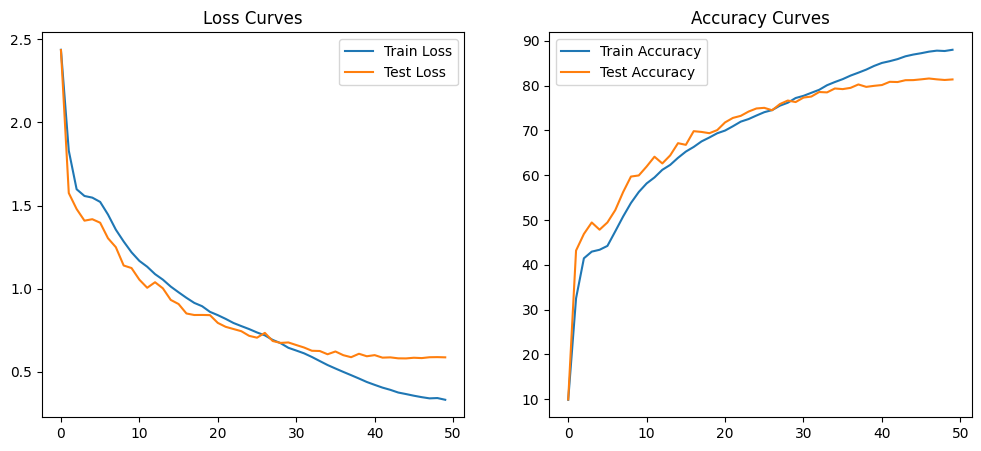

In [21]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.legend(); plt.title("Accuracy Curves")

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend(); plt.title("Loss Curves")

plt.show()

## Inference Visualization

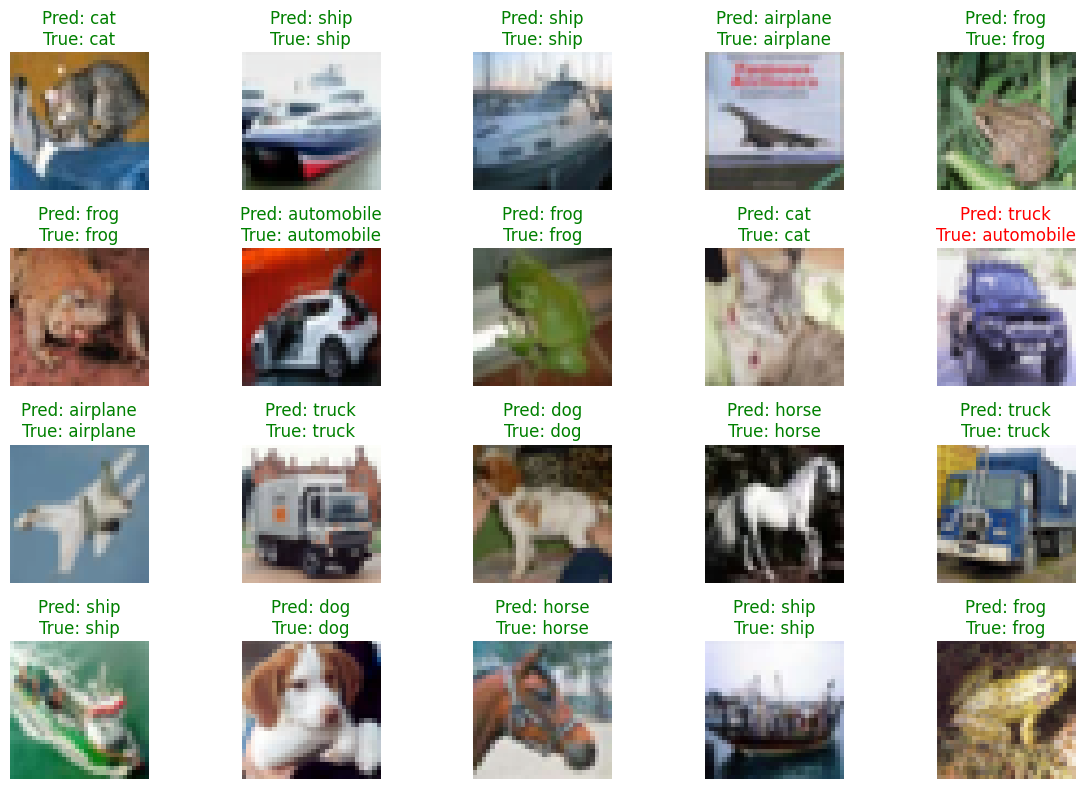

In [22]:

model.load_state_dict(torch.load("best_vit_cifar10.pth"))
model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

plt.figure(figsize=(12,8))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1,2,0)) * np.array(std) + np.array(mean))
    plt.title(f"Pred: {classes[preds[i].item()]}\nTrue: {classes[labels[i].item()]}",
          color='green' if preds[i] == labels[i] else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()